### Center mapping notebook for F1 tenth purposes

This notebook is used to map the center line (and the boundaries) of a racetrack of the f1-tenth competition. 
The .png image and the configuration file are used. 

In [1]:
from PIL import Image 
from tqdm import tqdm 
import numpy as np 
import potrace as pp 
from matplotlib import pyplot as plt 
%matplotlib inline 

filename = '/home/gnone/edoardo-ghignone/drivers/src/maps/smile.png' 


In [2]:
# image import, the image must be in grayscale
im = Image.open(filename)
im_np = np.asarray(im)
if len(im_np.shape) == 3:
    im_np = np.sum(im_np, axis=2)
#if im_np.shape != (2000,2000):
#    raise ValueError("something wrong with the image, the shape is {}".format(im_np.shape))
im_vec = np.clip(im_np, 0, 1)
im_bmp = pp.Bitmap(im_vec)

path = im_bmp.trace()
curves = path.curves
print("The total number of splines is: " + str(len(curves)))

The total number of splines is: 6


At this point we have the total number of splines that potrace found. Since I feel it is not certain that we will always only find the inner and the outer line, it is better to check how many of them there are. Usually there are 4. 

In [3]:
# create tesselation
# here we need to find which curves to use 

curve_ext = curves[2]
curve_ext = curve_ext.tesselate(curve_ext.adaptive, res=20)

curve_int = curves[5]
curve_int = curve_int.tesselate(curve_int.adaptive, res=20)

print("Number of points of internal curve: {}".format(len(curve_ext)))
print("Number of points of internal curve: {}".format(len(curve_int)))

tot_points = min([len(curve_ext), len(curve_int)])

Number of points of internal curve: 132
Number of points of internal curve: 119


In [4]:
# since the tesselation kinda sucks, I increase the number of points here 

def improve_tesselation(points):
    points = np.array(points)
    tot_len = 0
    len_points = len(points)
    for i in range(len_points-1):
        tot_len += np.linalg.norm(points[i+1] - points[i])
    tot_len += np.linalg.norm(points[0] - points[-1])

    max_size = tot_len/800
    new_points = []
    new_points.append((points[0]))
    for i in range(1, len_points):
        while np.linalg.norm(new_points[-1]-points[i]) > max_size:
            new_points.append(new_points[-1] + max_size*(points[i] - new_points[-1])/np.linalg.norm(points[i] - new_points[-1]))
        new_points.append(points[i])

    return new_points    

new_curve_ext = curve_ext
new_curve_int = curve_int
new_curve_ext = improve_tesselation(curve_ext)
new_curve_int = improve_tesselation(curve_int)


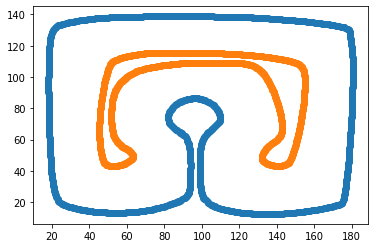

In [5]:
# this next block can be used to asess the quality of tesselation improvement

plt.figure()

plt.plot(np.array(new_curve_ext)[:, 0], np.array(new_curve_ext)[:, 1],'o')
plt.plot(np.array(new_curve_int)[:, 0], np.array(new_curve_int)[:, 1], 'o')

Here we start to create the points of the track

The idea is: 
1. find the two points around the start on the boundaries 
2. take the midpoint of them 
3. take two points on the boundaries nearest to this found point 
4. take the midpoint of them and save it
5. check if finished, if not go back to 1 but going forward on the boundaries from the last two found points

In [6]:
# here just some functions

from typing import List

# find points around starting point 

# starting point = 0.8007017, -0.2753365 with pose 4.1421595 (for SOCHI)
# starting point for circle [-75.0, -89]
# these numbers must be converted

start_point = [-9, -25]
start_pose = 3.1415

meters_per_pixel = 0.05
origin_meters= [-11.606540, -26.520793]

def convert_pixel_meter(pixel_coord: List[float] = None, meter_coord: List[float] = None, method: str = 'pm') -> List[float]:
    """
    Utility to convert a pixel coord to float. default converts pixels to meters, can do the opposite too

    Args:
        pixel_coord: tuple containing the coordinate in pixel
        meter_coord: tuple containing the coordinate in meter 
        method: can be either 'pm' for pixel->meters or 'mp'
    """

    if method == 'pm':
        
            out = [ coord * meters_per_pixel for coord in pixel_coord ]
            out = [ a+b for a,b in zip(out, origin_meters) ]
    elif method == 'mp':
        
            out = [ a-b for a,b in zip(meter_coord, origin_meters) ]
            #print(out)
            out = [ coord/meters_per_pixel for coord in out ]
    else:
        raise ValueError('method field can only be pm or mp')
    
    return out


# some tests
#print(convert_pixel_meter(pixel_coord=[1000,1000]))
#print(convert_pixel_meter(meter_coord=[0.8007017, -0.2753365], method='mp'))

def invert_y(point):
    tmp = convert_pixel_meter(meter_coord=point, method='mp')
    return convert_pixel_meter(pixel_coord=[tmp[0], 150-tmp[1]])

def find_nearest_idx(curve, point):
    """
    Function to find the point, nearest to a curve, given a point 
    """
    min_dist = 100000
    for i, coord in enumerate(curve):
        dist = sum([(a-b)**2 for a,b in zip(coord, point)]) # this finds the squared two norm distance btw the 2 points
        if dist < min_dist:
            min_dist = dist
            min_idx = i

    return min_idx

def avg_point(point_a, point_b):
    """
    Function to average between two points
    """
    return [(a+b)/2 for a,b in zip(point_a, point_b)]

def find_on_perp(curve, point, perp):
    """
    Function to find the point on a perpendicular to a point, given a point 
    """
    threshold = 7
    min_p = np.inf
    target_dist = np.inf
    perp = perp/np.linalg.norm(perp)
    for i, coord in enumerate(curve):
        vec = np.array(coord)-np.array(point)
        len_vec = np.linalg.norm(vec)
        if len_vec < threshold:
            perpity = np.abs(np.dot(vec/len_vec, perp))
            #print(np.linalg.norm(vec/len_vec))
            if perpity < 0.12:
                if len_vec < target_dist-0.3:
                    min_p = perpity
                    min_idx = i
                    target_dist = len_vec
                    
    
    #print(last_d)


    return min_idx


In [7]:
convert_pixel_meter(pixel_coord=[0, 0], method='pm')

[-11.60654, -26.520793]

In [8]:
start_point = invert_y(start_point)
print(start_point)


[-9.0, -20.541586000000002]


In [9]:
# we first need to prepare the points
# Here we set the beginning of the track at the nearest point wrt to the starting point

curve_ext_meters = [convert_pixel_meter(pixel_coord=coord) for coord in new_curve_ext]
curve_int_meters = [convert_pixel_meter(pixel_coord=coord) for coord in new_curve_int]

# outer line
min_idx = find_nearest_idx(curve_ext_meters, start_point)
curve_ext_mt_raddr = curve_ext_meters[min_idx:] + curve_ext_meters[:min_idx]


# inner line
min_idx = find_nearest_idx(curve_int_meters, start_point)
curve_int_mt_raddr = curve_int_meters[min_idx:] + curve_int_meters[:min_idx]


In [10]:
import time
# Here we actually implement the algorithm described above 
# NOTICE: the algorithm may fail due to list index out of range but that's fine

midline = []

# first we find the starting point
point = start_point
idx_ext = find_nearest_idx(curve_ext_mt_raddr, point)
idx_int = find_nearest_idx(curve_int_mt_raddr, point)

assert idx_ext == 0
assert idx_int == 0

point = avg_point(curve_ext_mt_raddr[idx_ext], curve_int_mt_raddr[idx_int])
midline.append(point)

incr = 55 # how many pieces we look forward at each timestep
upd = 0
skip_one = False
with tqdm(total=tot_points) as pbar:
    while True:

        # 1 
        if not skip_one:
            new_ext = idx_ext + incr
            new_int = idx_int + incr
            upd = incr

            if new_ext >= len(curve_ext_mt_raddr):
                break
        else:
            skip_one = False

        # 2
        point = avg_point(curve_ext_mt_raddr[new_ext], curve_int_mt_raddr[new_int])

        # 3
        new_ext = find_nearest_idx(curve_ext_mt_raddr, point)
        new_int = find_nearest_idx(curve_int_mt_raddr, point)
        #print(new_ext)
        #print(new_int)
        #time.sleep(1)

        # 4 
        point = avg_point(curve_ext_mt_raddr[new_ext], curve_int_mt_raddr[new_int])
        midline.append(point)

        # update progressbar
        pbar.update(upd)
        upd = 0

        # check 
        if (new_ext < idx_ext or new_int < idx_int) or (new_ext == idx_ext and new_int == idx_int):
            skip_one = True
            idx_ext += 1
            idx_int += 1
            new_ext = idx_ext
            new_int = idx_int
            upd = 1
            if new_ext >= len(curve_ext_mt_raddr):
                break
        else: 
            idx_ext = new_ext
            idx_int = new_int


880it [00:00, 5450.89it/s]


In [11]:
# here we can see how many points make up the line

print("The found midline is made up of {} points".format(len(midline)))


The found midline is made up of 17 points


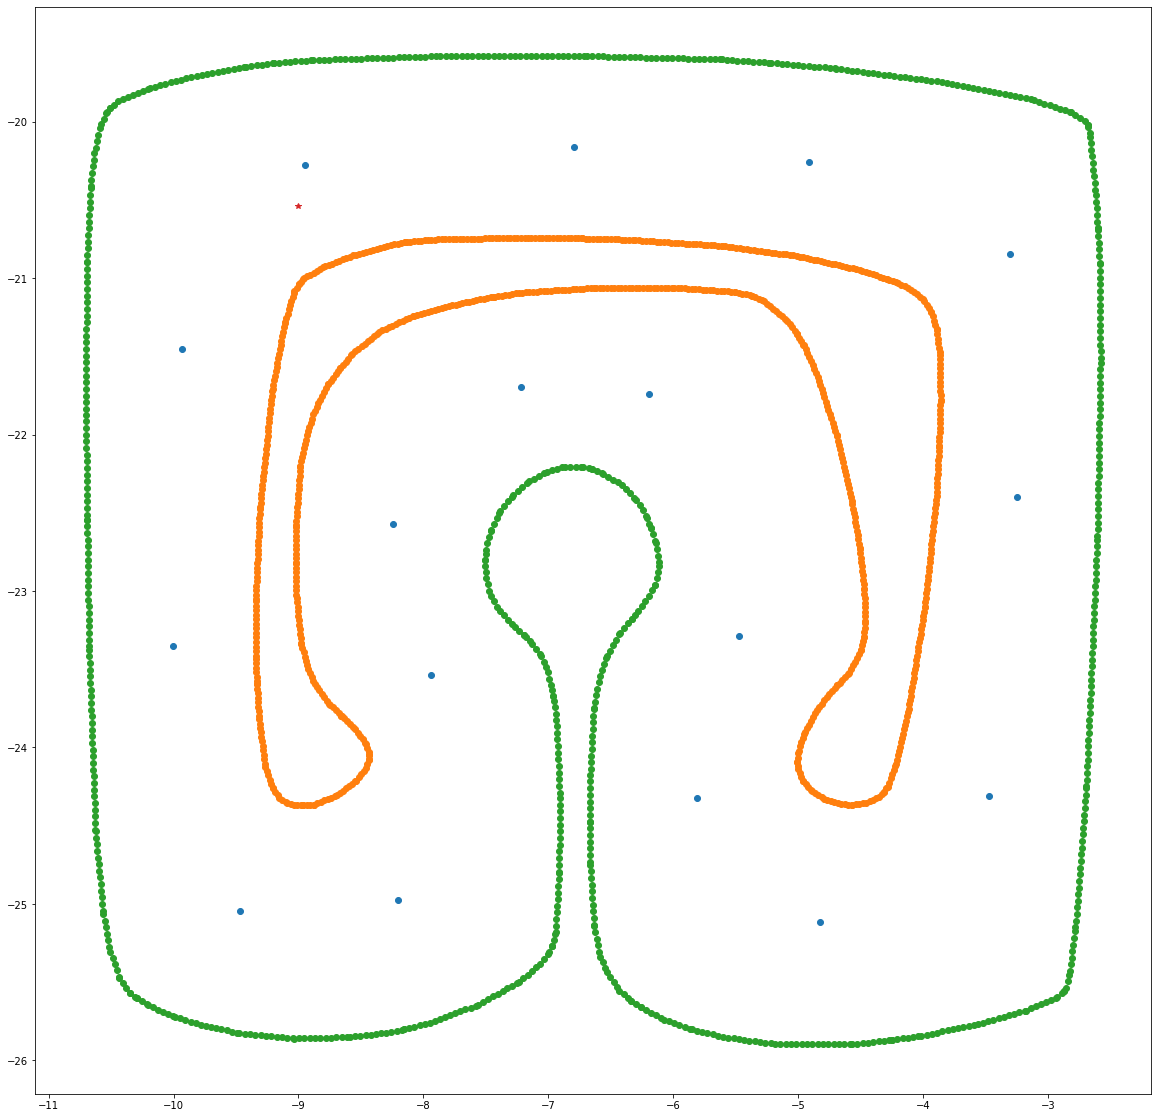

In [12]:
# this next block can be used to asess the quality of the center line obtained

plt.figure(figsize=(20, 20))

plt.plot(np.array(midline)[:, 0], np.array(midline)[:, 1], 'o')

plt.plot(np.array(curve_int_mt_raddr)[:, 0], np.array(curve_int_mt_raddr)[:, 1],'o')
plt.plot(np.array(curve_ext_mt_raddr)[:, 0], np.array(curve_ext_mt_raddr)[:, 1], 'o')

plt.plot(start_point[0], start_point[1], '*') # this can be used to check if the coordinate transformation is working

Now we would like to increase the number of segments here a little bit 

In [19]:
new_midline = []
for i, point in enumerate(midline):
    if i<len(midline)-1:
        new_midline.append(point)
        new_point=avg_point(point, midline[i+1])
        perp = [b-a for a,b in zip(new_point, midline[i+1])]
        near_ext = curve_ext_mt_raddr[find_nearest_idx(curve_ext_mt_raddr, new_point)]
        near_int = curve_int_mt_raddr[find_nearest_idx(curve_int_mt_raddr, new_point)]
        dist_ext = np.linalg.norm(np.array(near_ext) - np.array(new_point))
        dist_int = np.linalg.norm(np.array(near_int) - np.array(new_point))
        if dist_ext < dist_int:
            new_ext = near_ext
            new_int = curve_int_mt_raddr[find_on_perp(curve_int_mt_raddr, new_ext, perp)]
        else:
            new_int = near_int
            new_ext = curve_ext_mt_raddr[find_on_perp(curve_ext_mt_raddr, new_int, perp)]

        new_midline.append(avg_point(new_ext, new_int))
        #new_midline.append(new_point)
    else:
        new_midline.append(point)
        new_point=avg_point(point, midline[0])
        perp = [b-a for a,b in zip(new_point, midline[0])]
        new_ext = curve_ext_mt_raddr[find_on_perp(curve_ext_mt_raddr, new_point, perp)]
        new_int = curve_int_mt_raddr[find_on_perp(curve_int_mt_raddr, new_point, perp)]
        new_midline.append(avg_point(new_ext, new_int))




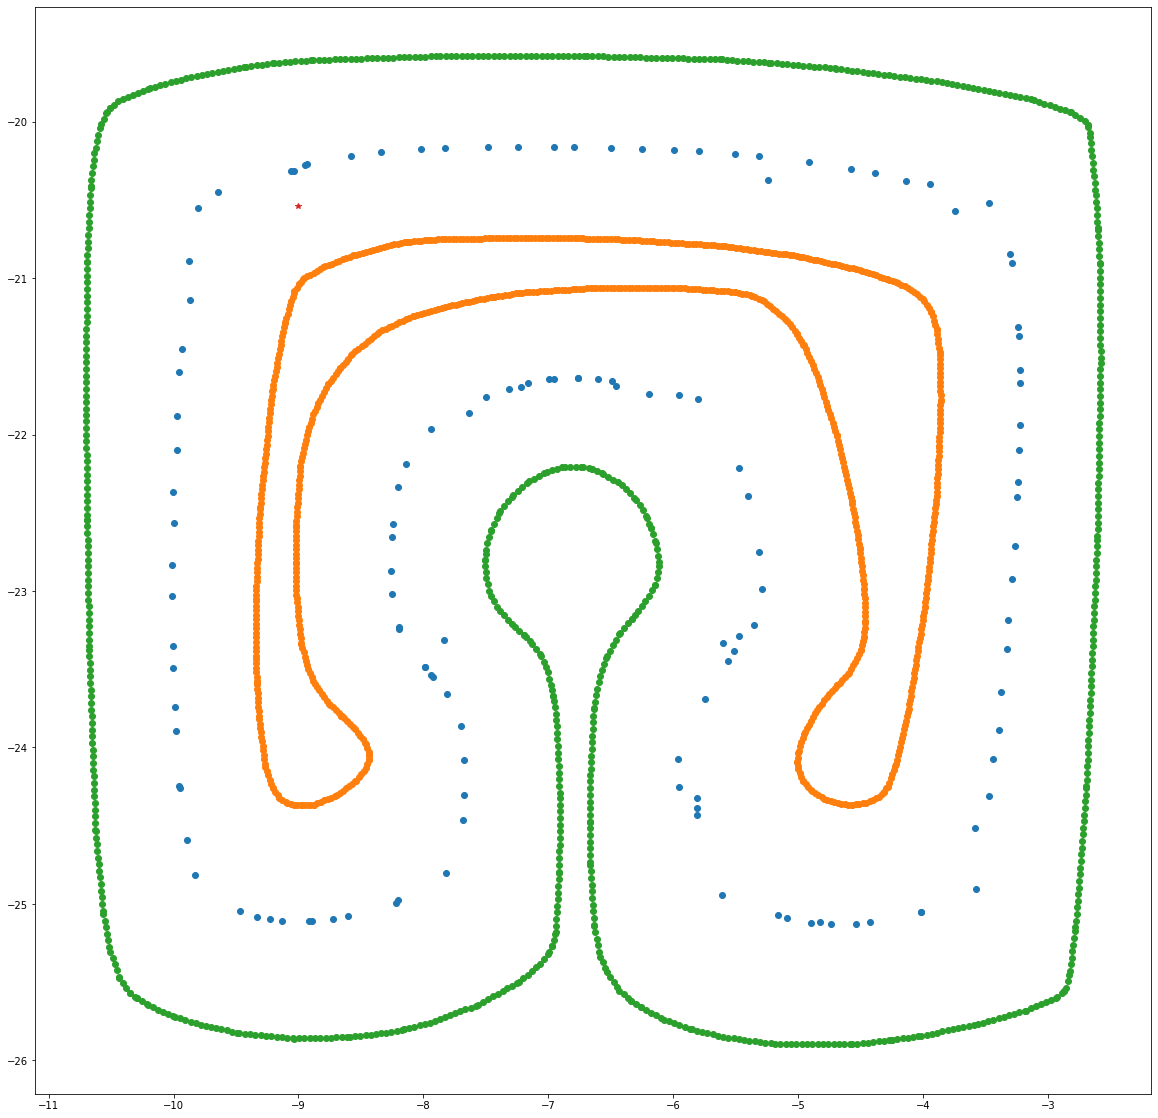

In [20]:
# this next block can be used to asess the quality of the center line obtained

plt.figure(figsize=(20, 20))

plt.plot(np.array(new_midline)[:, 0], np.array(new_midline)[:, 1], 'o')

plt.plot(np.array(curve_int_mt_raddr)[:, 0], np.array(curve_int_mt_raddr)[:, 1],'o')
plt.plot(np.array(curve_ext_mt_raddr)[:, 0], np.array(curve_ext_mt_raddr)[:, 1], 'o')

plt.plot(start_point[0], start_point[1], '*') # this can be used to check if the coordinate transformation is working

We now need to find the boundaries around the center line, but it is easy, just take the points on the boundaries that are nearest to the center points. 

In [18]:
midline = new_midline

In [13]:
extline = []
intline = []

for i, point in enumerate(midline):
    if i == len(midline)-1:
        ind_post=0
    else:
        ind_post = i+1
    perp = [b-a for a,b in zip(midline[i-1], midline[ind_post])]
    extline.append(curve_int_mt_raddr[find_on_perp(curve_int_mt_raddr, point, perp)])
    intline.append(curve_ext_mt_raddr[find_on_perp(curve_ext_mt_raddr, point, perp)])

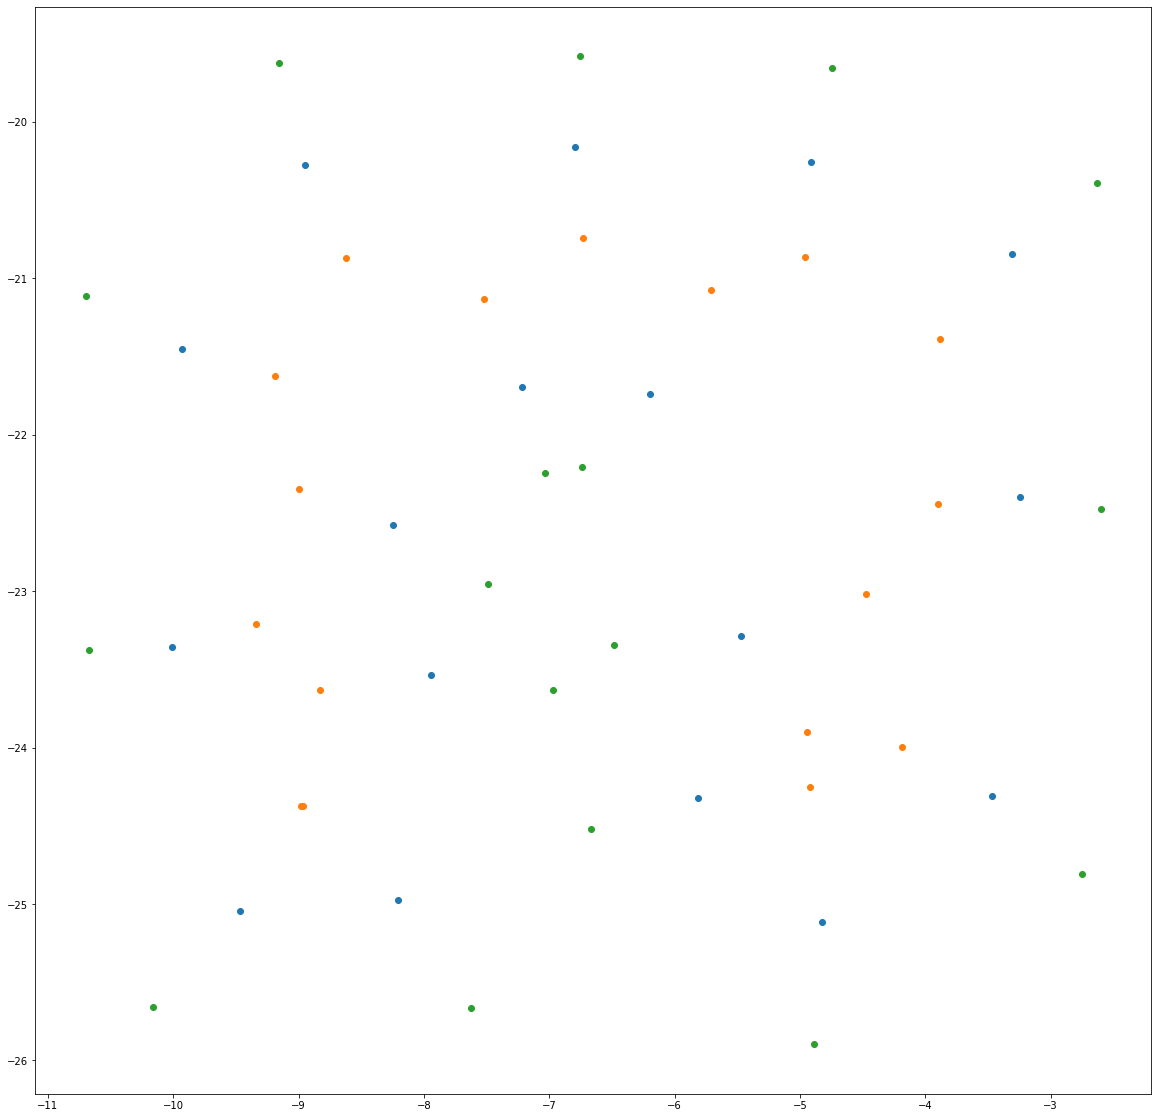

In [14]:
# this next block can be used to asess the quality of the final result
plt.figure(figsize=(20, 20))

plt.plot(np.array(midline)[:, 0], np.array(midline)[:, 1], 'o')

plt.plot(np.array(extline)[:, 0], np.array(extline)[:, 1], 'o')
plt.plot(np.array(intline)[:, 0], np.array(intline)[:, 1], 'o')


We will now need to do some final processing before saving the points to file


In [15]:
# we will first need to invert the y coordinate

intline = [invert_y(a) for a in intline]
midline = [invert_y(a) for a in midline]
extline = [invert_y(a) for a in extline]

start_point = invert_y(start_point)


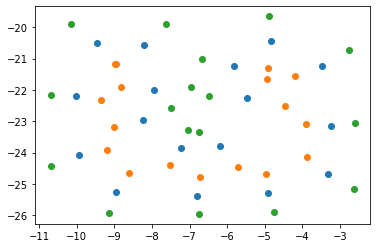

In [16]:
# then we have to check if the race is mapped in the proper direction, otherwise we have to reverse it 
# this plot shows the first part of the track, if it is ok RUN the next block otherwise DON'T RUN it

num = 20
plt.plot(np.array(midline)[:num, 0], np.array(midline)[:num, 1], 'o')

plt.plot(np.array(extline)[:num, 0], np.array(extline)[:num, 1], 'o')
plt.plot(np.array(intline)[:num, 0], np.array(intline)[:num, 1], 'o')


In [17]:
# we need to reorder the points if the race track is not analysed the proper way

intline.reverse()
midline.reverse()
extline.reverse()

intline = [intline[-1]] + intline[:-1]
midline = [midline[-1]] + midline[:-1]
extline = [extline[-1]] + extline[:-1]


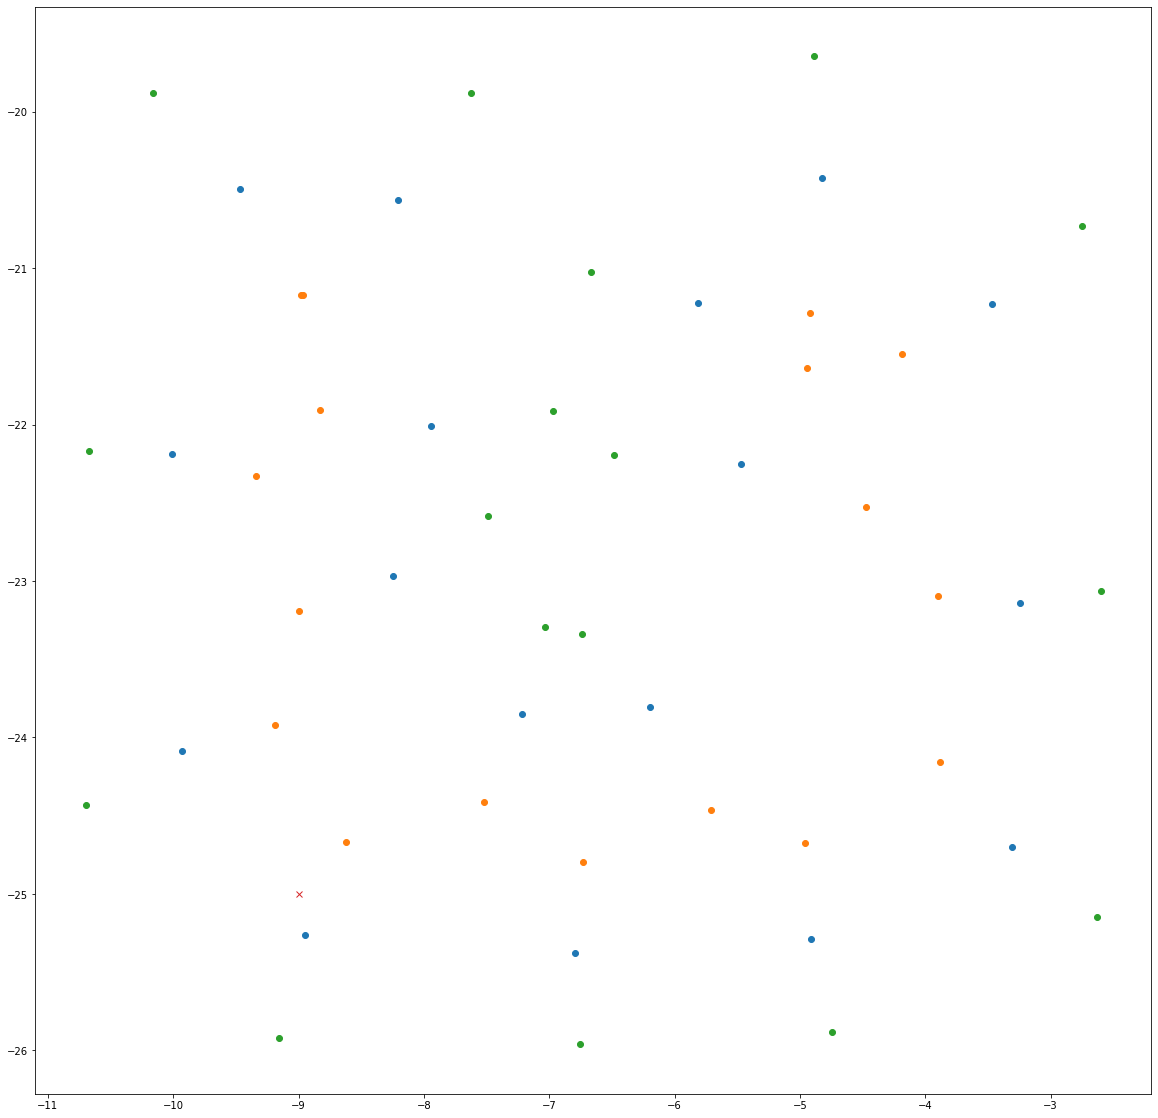

In [18]:
# this next block can be used to asess the quality of the final result

plt.figure(figsize=(20, 20))

hor = -0
plt.plot(np.array(midline)[:, 0], np.array(midline)[:, 1], 'o')

plt.plot(np.array(extline)[:, 0], np.array(extline)[:, 1], 'o')
plt.plot(np.array(intline)[:, 0], np.array(intline)[:, 1], 'o')

if True:
    plt.plot(start_point[0],start_point[1],'x')


#a = [0.8762304900695898,0.8778278054201752,0.8790729978118739,0.8800176932748008,0.8807091290757418,0.8811880028661303,0.8814940519224373,0.88166299087414,0.8817283627972782,0.8817197699266449,0.8816642289116559,0.8815776633520789,0.8812728285580891,0.8808938920259523,0.8803253067250457,0.879672103614734,0.8788607384901481,0.8779687540781964,0.876948862292212,0.8758586948063163,0.8746681626860803,0.8734194407608337,0.8720995721930361,0.8707158226520165,0.8692747969237663,0.8677824545405319,0.8662441259924171,0.8646645357168797,0.8630478697178298,0.8613977889093412,0.8597175500182929,0.8580099871142255,0.8562775327760159,0.8545222489613022,0.8527458390649019,0.8509497125310993,0.8491350008148401,0.8473025774216064,0.8454530707989657,0.8435868767512459]
#b = [-0.17757999080771414,-0.17608584371317781,-0.17491296930443462,-0.17401806290097427,-0.1733595896241075,-0.17290120053793812,-0.17260625240478686,-0.17244164527116232,-0.17237601365337216,-0.17238151796228235,-0.17243260943298375,-0.1725168012431557,-0.1728064363747655,-0.17317555932593715,-0.17372045710101167,-0.1743565420541541,-0.17513832292299483,-0.1760073332094452,-0.17699420798288173,-0.17805742119014,-0.1792136339574133,-0.18043338765452596,-0.18172170665590895,-0.18307133425449273,-0.18447567978885676,-0.18592879863997067,-0.18742537572370954,-0.18896070182264918,-0.19053060619629,-0.19213144199389237,-0.19375996650076346,-0.19541335744017183,-0.19708919068636446,-0.1987854084959079,-0.20050030653467507,-0.2022324690960523,-0.20398075234085086,-0.20574426351691363,-0.20752234738286843,-0.20931457316599797]
#plt.plot(a,b, 'x')


In [19]:
# we can now save these coordinates in a text file 
# CHANGE the name of the text file with the name of the track

with open('smile_waypoints.txt', 'w') as file:
    file.write("inner_point, midpoint, outer_point, \n")
    for i in range(len(extline)):
        file.write("{}, {}, {}, \n".format(intline[i], midline[i], extline[i]))
    